## NIPS CM and PLS Spin Test 

### Imports

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from env.imports import *

In [9]:
import importlib
import data

import data.data_utils
from data.data_load import load_transcriptome, load_connectome, load_coords
from data.data_viz import plot_connectome, plot_connectome_with_labels, plot_transcriptome
from models import *
from data import * 
from sim import *

import models
import models.metrics
from models.metrics import *

from sim.null import fit_cm, fit_cm_closed, fit_cm_closed_with_scalar_bias, fit_cm_closed_with_gcv, grid_search_alpha_with_gcv
from sim.null import get_best_pls_model, run_spin_test, run_spin_test_random, run_spin_test_precomputed_colored


## Specify connectome and transcriptome

Assign features and targets

In [10]:
# S400
X = load_transcriptome(parcellation='S400', omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='expression')
X_pca = load_transcriptome(parcellation='S400', run_PCA=True, omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='expression')
Y_sc = load_connectome(parcellation='S400', omit_subcortical=False, measure='SC', hemisphere='both', include_labels=False)
Y_fc, region_labels, lh_indices, rh_indices = load_connectome(parcellation='S400', omit_subcortical=False, measure='FC', hemisphere='both', include_labels=True)
Y = Y_fc
coords = load_coords(parcellation='S400', omit_subcortical=True, hemisphere='both')

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Subset all data using valid indices
X = X[valid_indices]
X_pca = X_pca[valid_indices]
Y = Y[valid_indices][:, valid_indices]


Number of components for 95% variance PCA: 27


## Find Best True Fit SCM model

alpha=0      | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.00 | Tr(H)=729.00
alpha=1e-05  | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.00 | Tr(H)=729.00
alpha=0.0001 | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.00 | Tr(H)=729.00
alpha=0.001  | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.01 | Tr(H)=728.99
alpha=0.01   | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.06 | Tr(H)=728.94
alpha=0.1    | GCV=1.1322e-07 | Residual=6.9415e+01 | τ=206296.65 | Tr(H)=728.35
alpha=1      | GCV=1.1321e-07 | Residual=6.9415e+01 | τ=206302.44 | Tr(H)=722.56
alpha=10     | GCV=1.1332e-07 | Residual=6.9465e+01 | τ=206355.23 | Tr(H)=669.77
alpha=100    | GCV=1.1874e-07 | Residual=7.1201e+01 | τ=206630.65 | Tr(H)=394.35


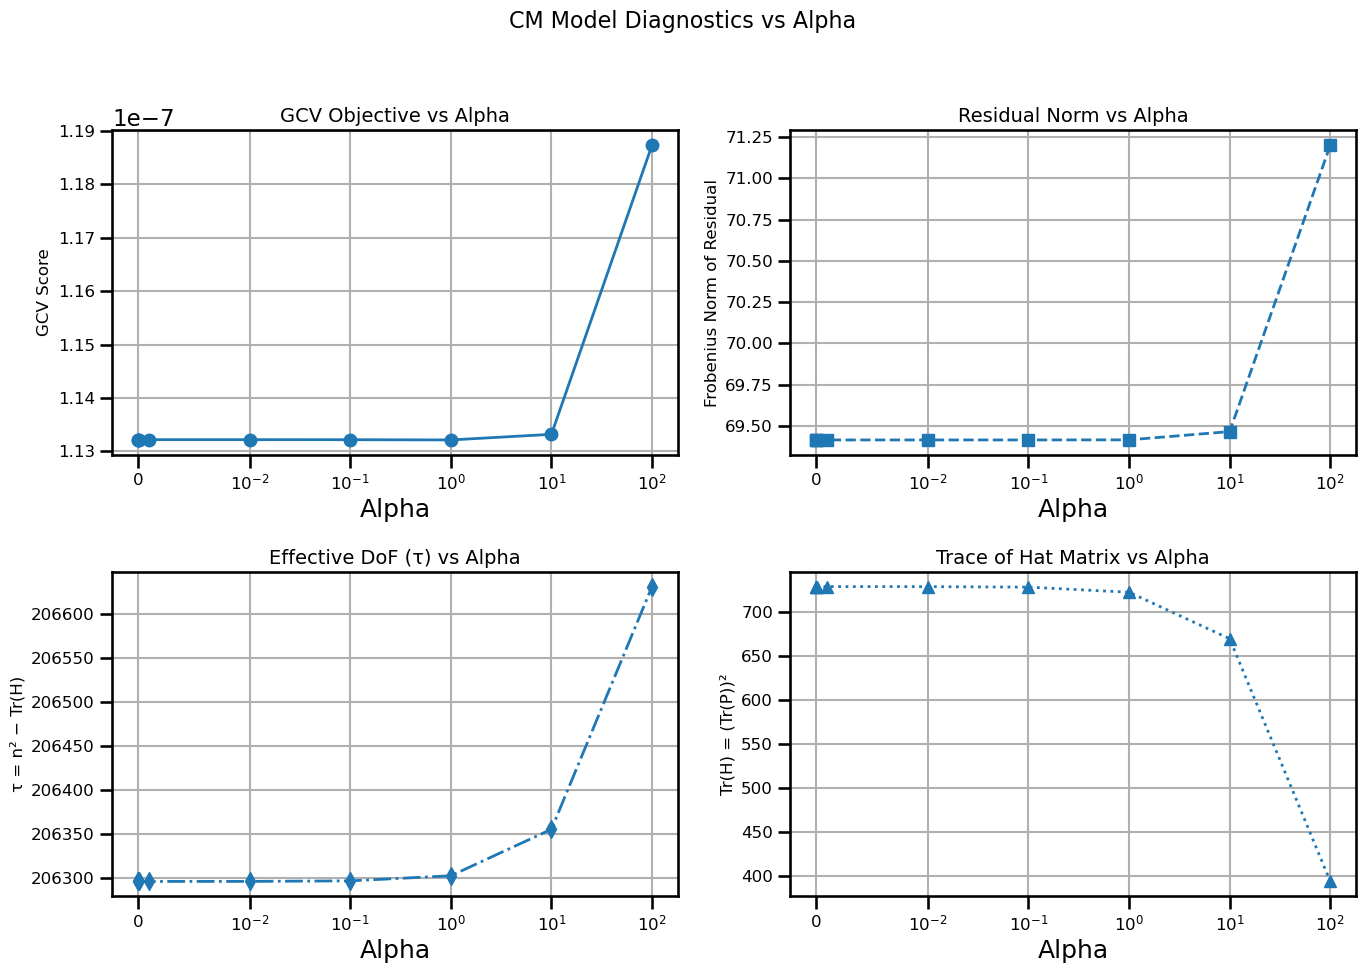

In [11]:
# # Define alpha values and run search
alphas = [0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
results = grid_search_alpha_with_gcv(X_pca, Y, alphas)


CM model metrics:
Pearson r: 0.560
R-squared: 0.30452
MSE: 0.02327


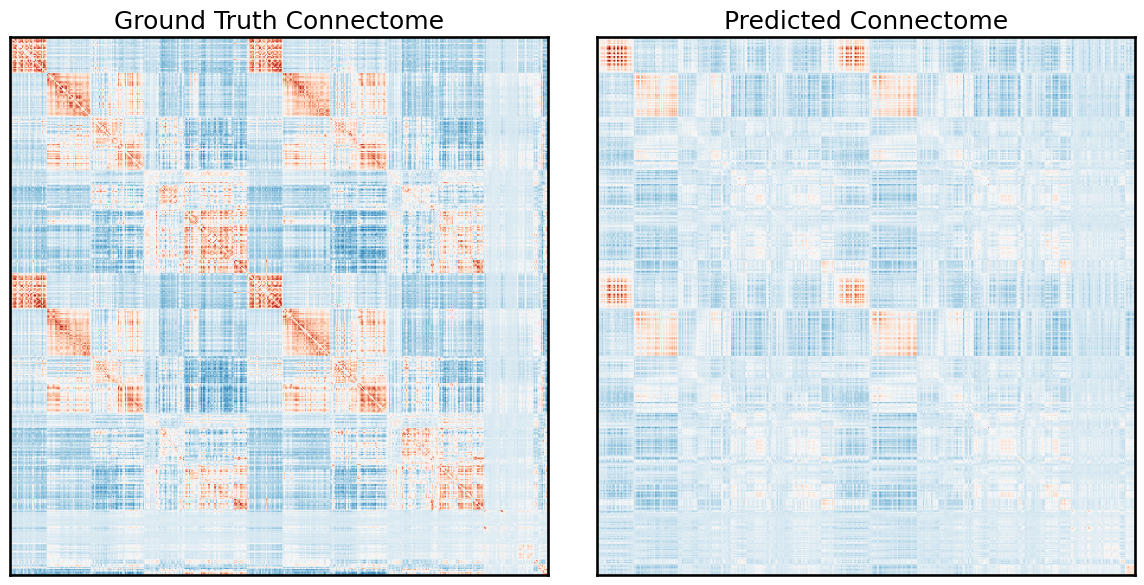

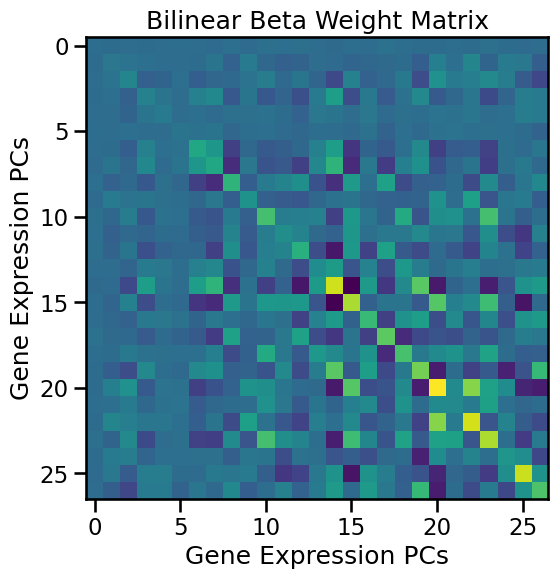

In [104]:
O, Y_pred = fit_cm_closed(X_pca, Y, alpha=0.1, plot=True)


CM model metrics:
Pearson r: 0.560
R-squared: 0.31329
MSE: 0.02298


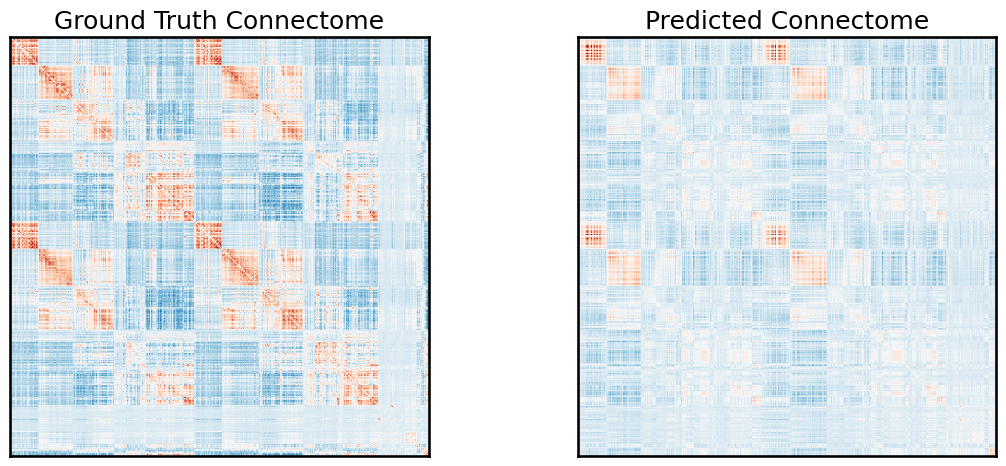

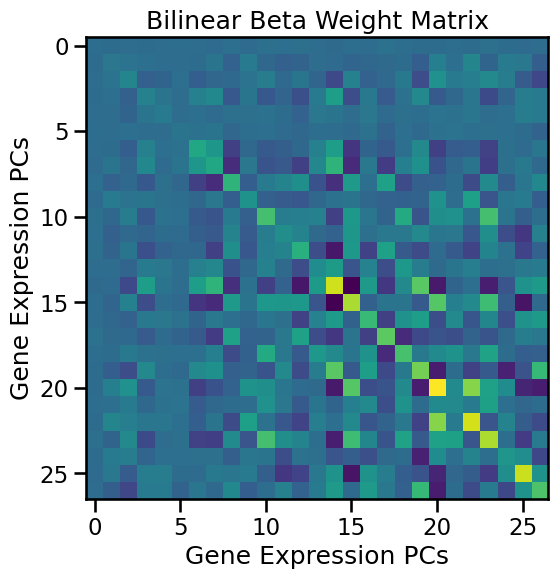

In [13]:
O, b, Y_pred = fit_cm_closed_with_scalar_bias(X_pca, Y, alpha=0.1, plot=True)

## Fit Best True PLS Model

5


10
15
20
25


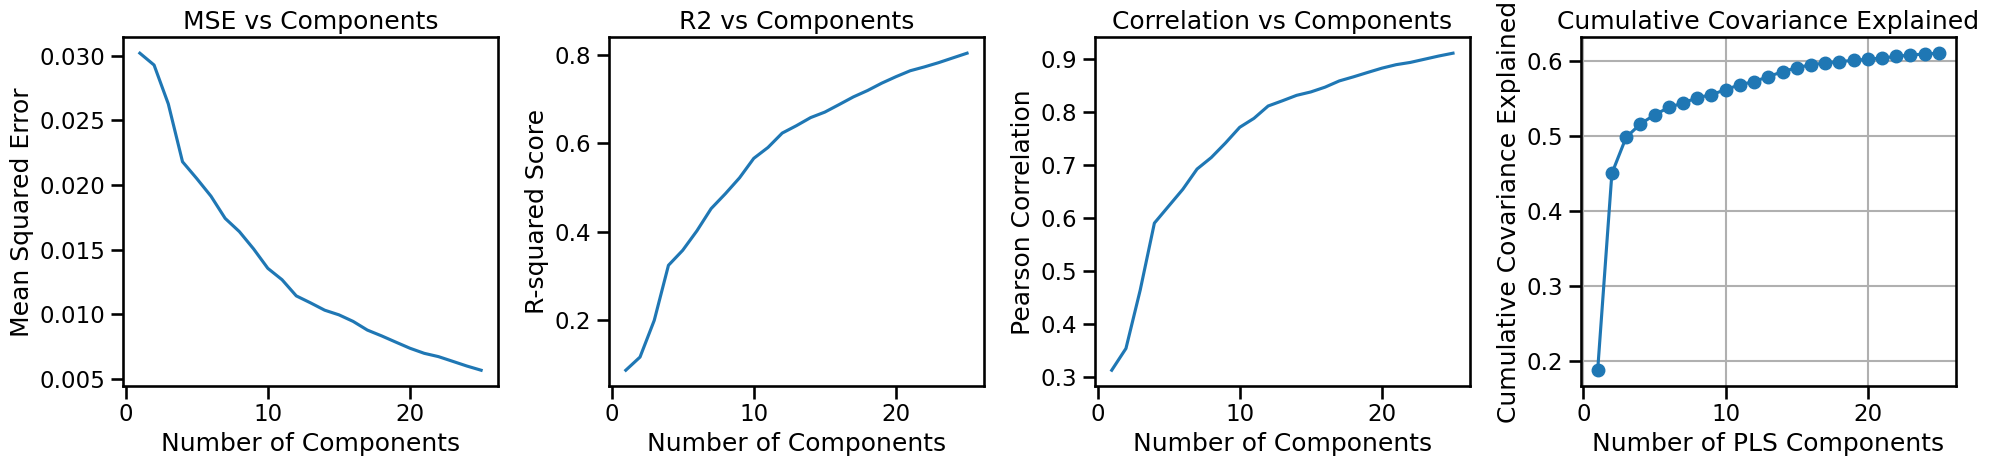

Best model performance (at elbow point):
Number of components: 9
MSE: 0.0151
R2: 0.5219
Mean correlation: 0.7416


In [14]:
best_pls_model, metrics = get_best_pls_model(X, Y, max_components=25)

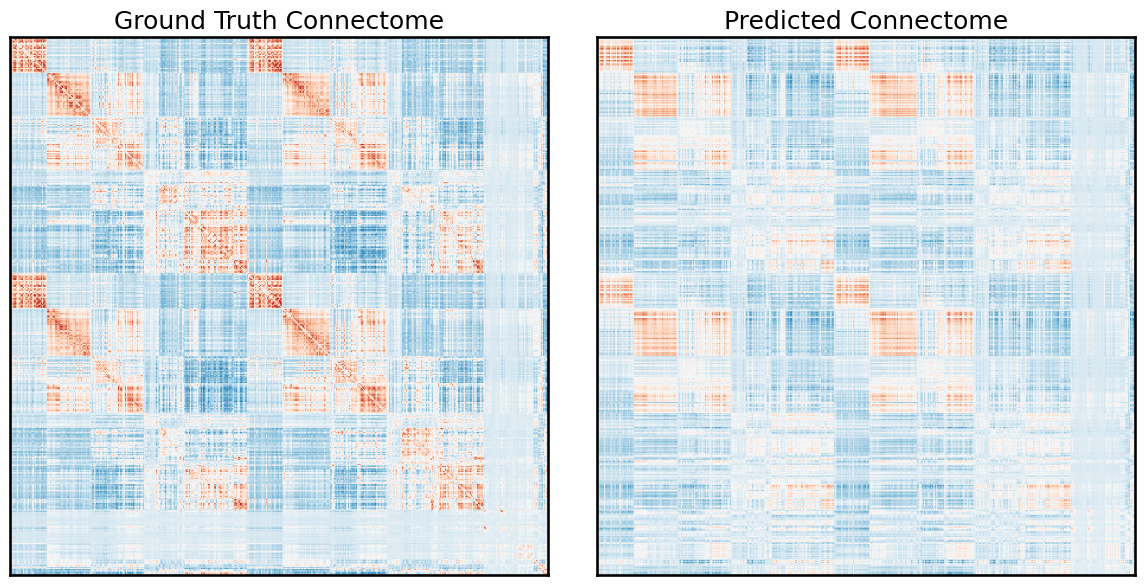

In [103]:
# Get predictions from best PLS model
Y_pred = best_pls_model.predict(X)

# Create figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot ground truth connectome
im1 = ax1.imshow(Y, cmap='RdBu_r', vmin=-0.75, vmax=1)
ax1.set_title('Ground Truth Connectome')
ax1.set_xticks([])
ax1.set_yticks([])

# Plot predicted connectome  
im2 = ax2.imshow(Y_pred, cmap='RdBu_r', vmin=-0.75, vmax=1)
ax2.set_title('Predicted Connectome')
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()

## Comparison to null spin tests

In [19]:
spins_df_1k = pd.read_csv('./data/enigma/1000_null_spins.csv')
spins_df_10k = pd.read_csv('./data/enigma/10000_null_spins.csv')
spins_df_spatial_random = pd.read_csv('./data/enigma/1000_spatial_random_spins.csv')
spins_df_random = pd.read_csv('./data/enigma/1000_true_random_spins.csv')
spins_df_10k.head()

cortical_spins  \
0  [1, 6, 4, 0, 2, 69, 12, 68, 5, 3, 10, 7, 15, 1...   
1  [21, 15, 193, 191, 190, 194, 19, 143, 144, 189...   
2  [122, 6, 3, 1, 4, 69, 12, 0, 2, 9, 10, 7, 19, ...   
3  [175, 172, 137, 117, 170, 136, 113, 138, 134, ...   
4  [0, 1, 2, 6, 4, 5, 12, 7, 8, 3, 9, 11, 15, 92,...   

                                   subcortical_spins  cortical_cost  \
0  [0, 33, 2, 29, 1, 5, 6, 7, 8, 3, 10, 11, 12, 1...    9868.096901   
1  [2, 9, 13, 12, 5, 6, 52, 49, 33, 7, 48, 10, 32...    9643.503872   
2  [31, 48, 47, 52, 46, 28, 30, 34, 7, 51, 10, 49...   10587.258836   
3  [53, 55, 46, 49, 54, 48, 5, 33, 4, 51, 32, 31,...    9722.312520   
4  [53, 55, 54, 48, 49, 50, 13, 9, 6, 52, 2, 47, ...    8802.011771   

   subcortical_cost    total_cost  mean_error_rank  total_cost_rank  \
0        612.102793  10480.199694        16.666667              8.0   
1       1295.744937  10939.248809       151.666667             13.0   
2       3044.556141  13631.814976       152.333333            441.0   
3       2569.249866  12291.562385       181.666667             82.0   
4       2648.851327  11450.863098       215.333333             26.0   

   SA_error_rank  poly_error_rank  standardized_SA_error  ...   poly_a1  \
0            4.0             38.0               0.609384  ...  1.096968   
1          374.0             68.0               1.591515  ...  1.061321   
2            6.0             10.0               0.621569  ...  1.082026   
3          340.0            123.0               1.547915  ...  1.074919   
4            5.0            615.0               0.609793  ...  1.025928   

    poly_a2   poly_a3   poly_a4  poly_a1_PCA  poly_a2_PCA  poly_a3_PCA  \
0 -0.028375  0.000318 -0.000001     1.049116    -0.032066     0.000341   
1 -0.028272  0.000327 -0.000001     1.052804    -0.034917     0.000388   
2 -0.029022  0.000340 -0.000001     1.050206    -0.032869     0.000358   
3 -0.030991  0.000379 -0.000001     1.043412    -0.034916     0.000391   
4 -0.025585  0.000291 -0.000001     0.997005    -0.028756     0.000293   

   poly_a4_PCA  pearsonr_CM  pearsonr_PLS  
0    -0.000001     0.407118      0.681995  
1    -0.000001     0.344573      0.659336  
2    -0.000001     0.381050      0.624501  
3    -0.000001     0.353389      0.597952  
4    -0.000001     0.427836      0.676105  

[5 rows x 27 columns]

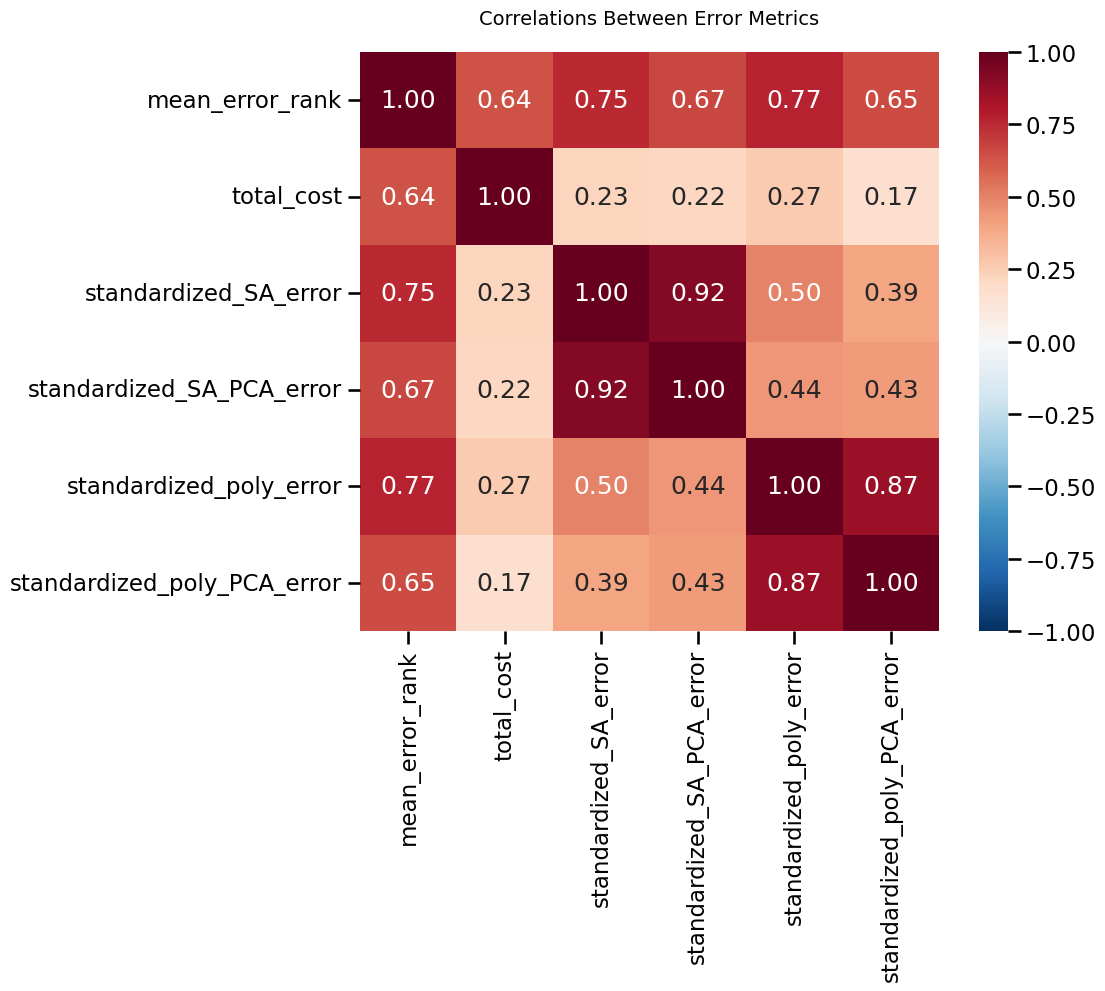

In [20]:
# Calculate correlations between error metrics
error_columns = ['mean_error_rank', 'total_cost', 'standardized_SA_error', 'standardized_SA_PCA_error', 
                'standardized_poly_error', 'standardized_poly_PCA_error']

# Compute correlation matrix
corr_matrix = spins_df_1k[error_columns].corr()

# Create figure
plt.figure(figsize=(12,10))

# Plot heatmap
sns.heatmap(corr_matrix, 
            annot=True, # Show correlation values
            cmap='RdBu_r', # Red-Blue diverging colormap
            vmin=-1, vmax=1, # Fix scale from -1 to 1
            center=0, # Center colormap at 0
            square=True, # Make cells square
            fmt='.2f') # Round correlation values to 2 decimal places

plt.title('Correlations Between Error Metrics', fontsize=14, pad=20)
plt.tight_layout()
plt.show()




Fit spatial null model: 

- Idea is that autocorrelation in gene expression, X, may drive the model solution
- To address this we can generate a spatial permutation of either the gene expression data or the connectome data and refit the model
- Here we will permute the target data as in Hansen, 2021

- The spin test embodies the null hypothesis that genes and connectivity values are spatially correlated with each other because of inherent spatial autocorrelation.
- In Hansen, 2021, the P value is computed as the proportion of null singular values that are greater in magnitude than the empirical singular values.
- Thus, the P value represents the probability that the observed spatial correspondence between genes and connectivity values could occur by randomly correlating maps with comparable spatial autocorrelation

- In our case the null distribution could be the pearson-r values (or other metrics) of the best model as determined by elbow point.


Quick reload in data subsetting for valid indices

In [21]:
# S400
X = load_transcriptome(parcellation='S400', omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='expression')
X_pca = load_transcriptome(parcellation='S400', run_PCA=True, omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='expression')
Y_sc = load_connectome(parcellation='S400', omit_subcortical=False, measure='SC', hemisphere='both', include_labels=False)
Y_fc, region_labels, lh_indices, rh_indices = load_connectome(parcellation='S400', omit_subcortical=False, measure='FC', hemisphere='both', include_labels=True)
Y = Y_fc
coords = load_coords(parcellation='S400', omit_subcortical=True, hemisphere='both')

# Find rows that are not all NaN - necessary for gene expression data with unsampled regions
valid_indices = ~np.isnan(X).all(axis=1)

# Subset all data using valid indices
X = X[valid_indices]
X_pca = X_pca[valid_indices]
Y = Y[valid_indices][:, valid_indices]

Number of components for 95% variance PCA: 27


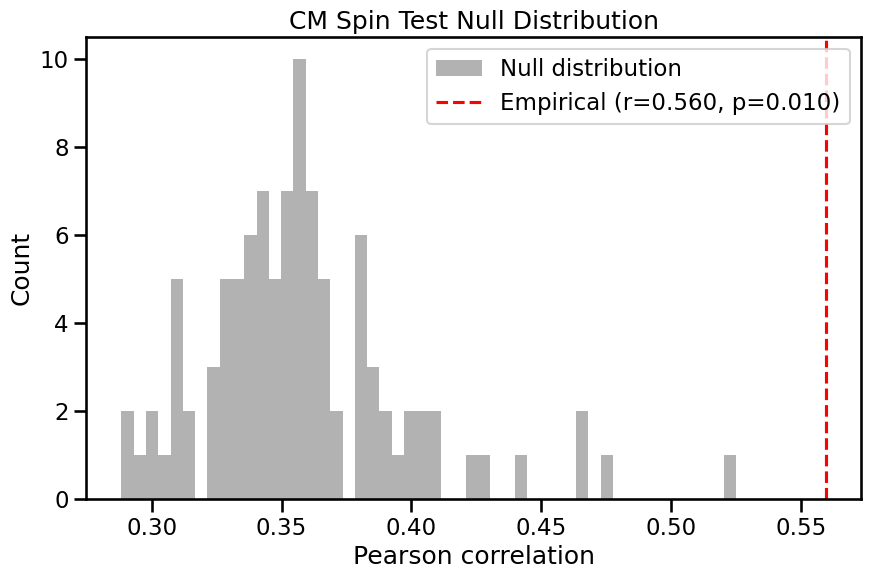

In [26]:
empirical_corr, p_value, null_distribution = run_spin_test(
    X=X_pca,
    valid_indices=valid_indices,
    Y_true=Y,
    spins_df=spins_df_10k,
    model_type='CM',
    sort_spins='mean_error_rank',
    n_perms=100, 
    pre_fit=True
)

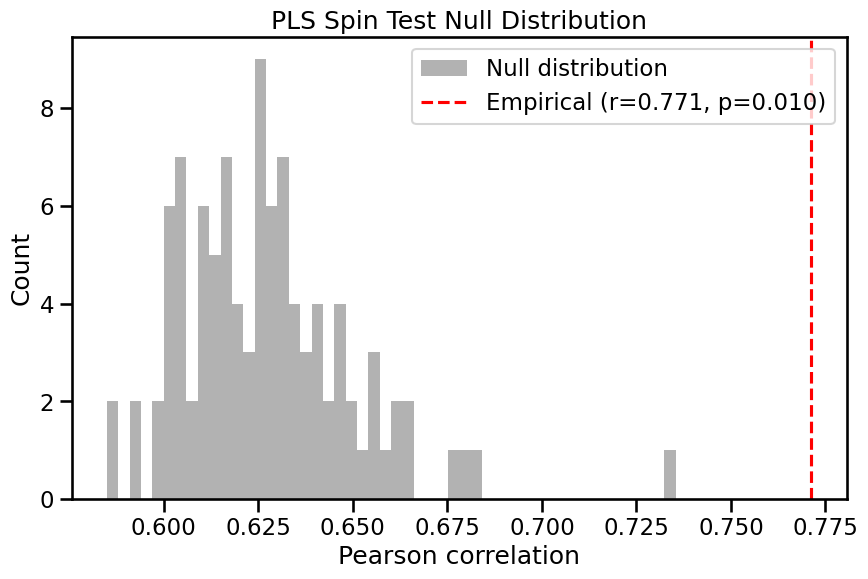

In [28]:
empirical_corr, p_value, null_distribution = run_spin_test(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y, 
    spins_df=spins_df_10k,
    model_type='PLS',
    num_components=10,
    sort_spins='mean_error_rank',
    n_perms=100, 
    pre_fit=True
)

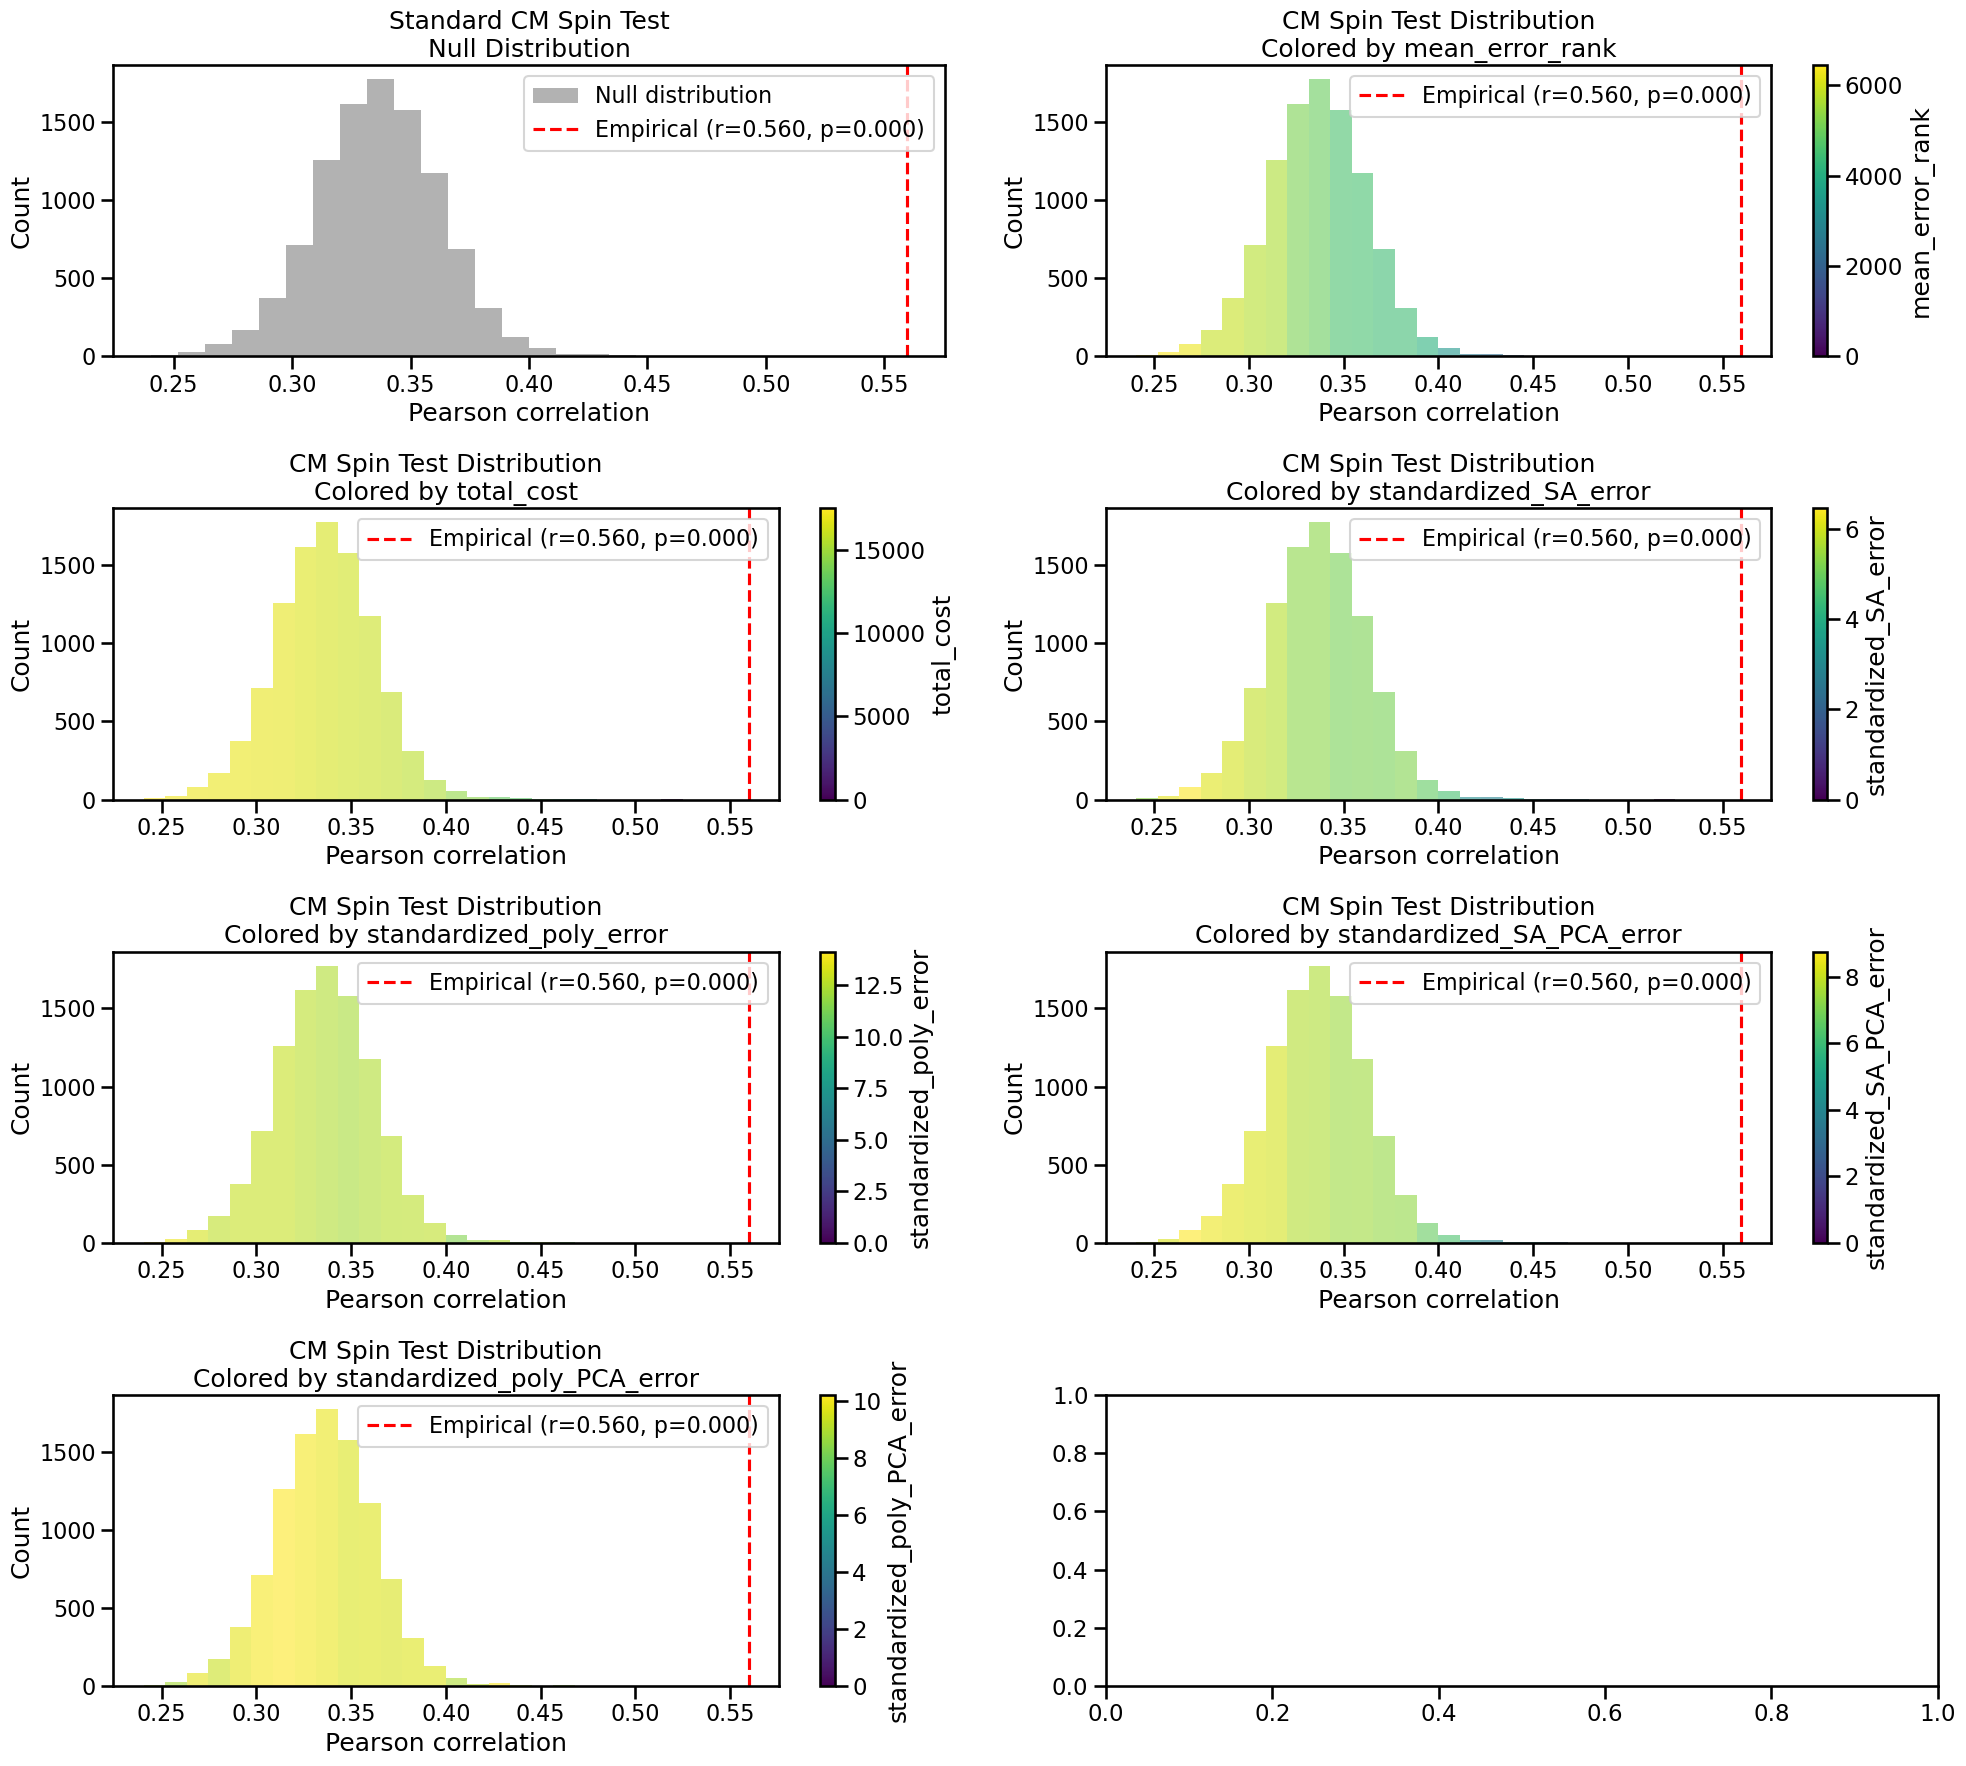

In [40]:
empirical_corr, p_value, null_distribution, error_metrics = run_spin_test_precomputed_colored(
    X=X_pca,
    valid_indices=valid_indices,
    Y_true=Y, 
    spins_df=spins_df_10k,
    model_type='CM',
    sort_spins='mean_error_rank',
    n_perms=10000,
    bins=25, 
    pre_fit=True

)

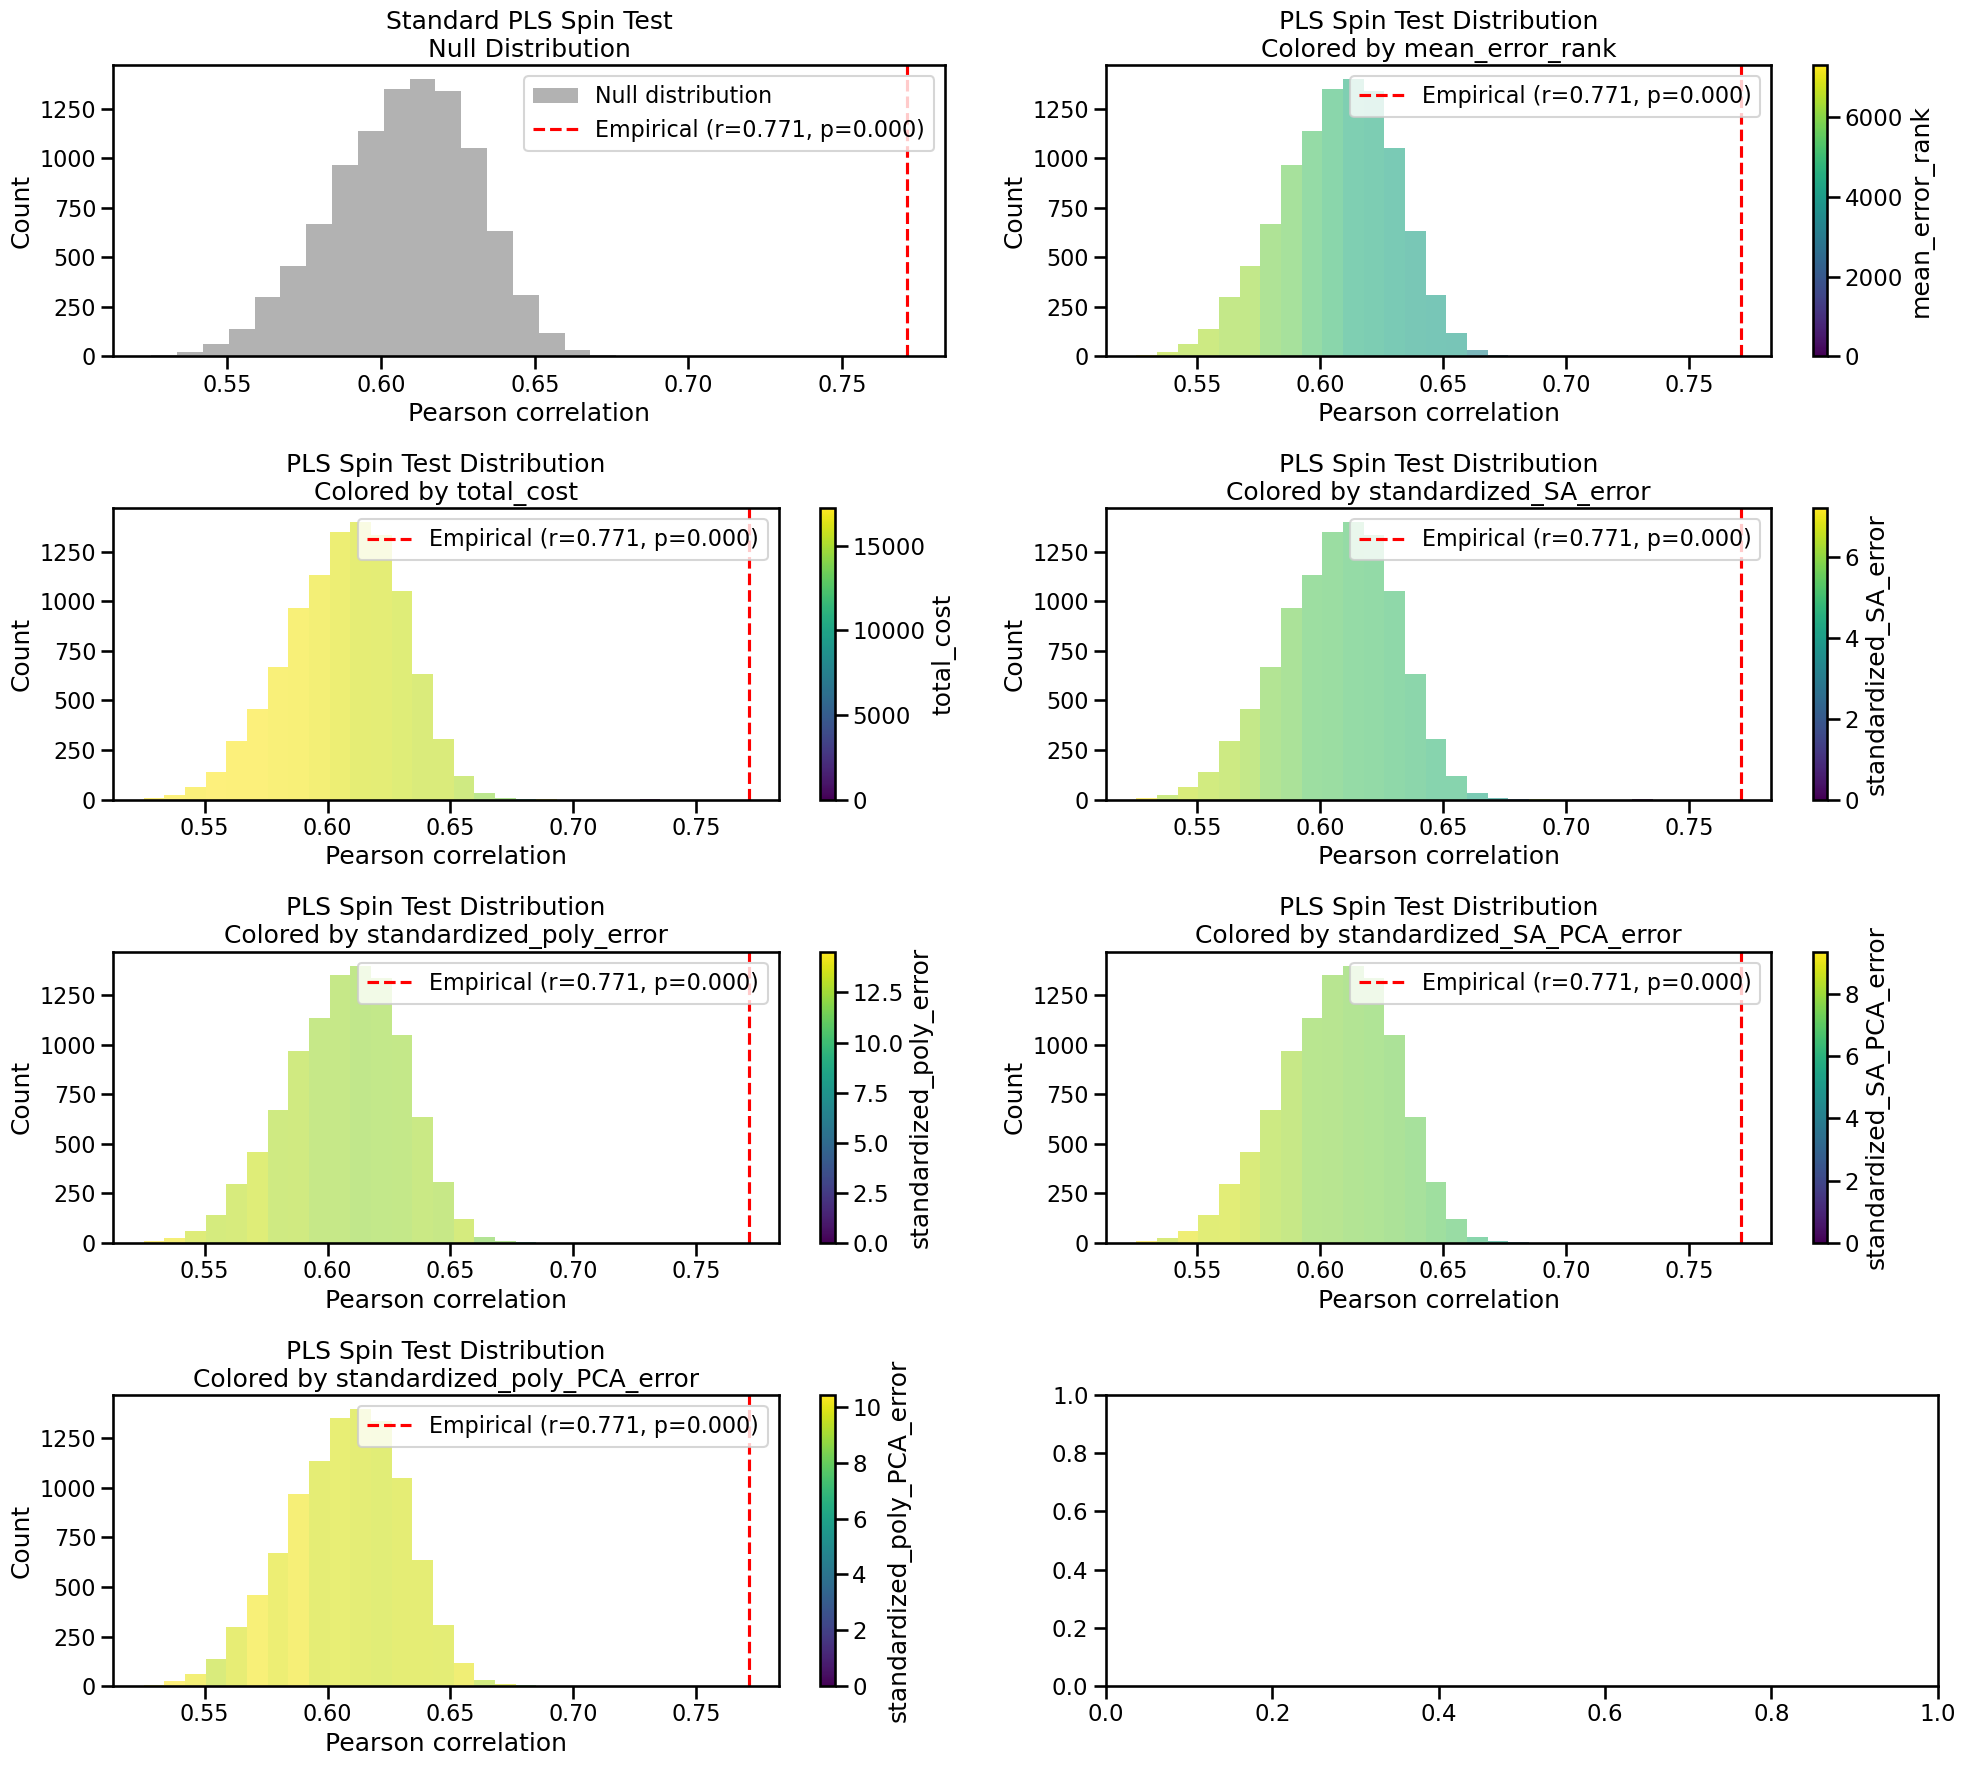

In [42]:
empirical_corr, p_value, null_distribution, error_metrics = run_spin_test_precomputed_colored(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y, 
    spins_df=spins_df_10k,
    model_type='PLS',
    sort_spins='mean_error_rank',
    n_perms=10000,
    bins=25, 
    pre_fit=True
)

#### Compute null distributions for all permutation tests

Generate distribution for all 10k spins

permutation: 0
permutation: 50
permutation: 100
permutation: 150
permutation: 200
permutation: 250
permutation: 300
permutation: 350
permutation: 400
permutation: 450
permutation: 500
permutation: 550
permutation: 600
permutation: 650
permutation: 700
permutation: 750
permutation: 800
permutation: 850
permutation: 900
permutation: 950
permutation: 1000
permutation: 1050
permutation: 1100
permutation: 1150
permutation: 1200
permutation: 1250
permutation: 1300
permutation: 1350
permutation: 1400
permutation: 1450
permutation: 1500
permutation: 1550
permutation: 1600
permutation: 1650
permutation: 1700
permutation: 1750
permutation: 1800
permutation: 1850
permutation: 1900
permutation: 1950
permutation: 2000
permutation: 2050
permutation: 2100
permutation: 2150
permutation: 2200
permutation: 2250
permutation: 2300
permutation: 2350
permutation: 2400
permutation: 2450
permutation: 2500
permutation: 2550
permutation: 2600
permutation: 2650
permutation: 2700
permutation: 2750
permutation: 28

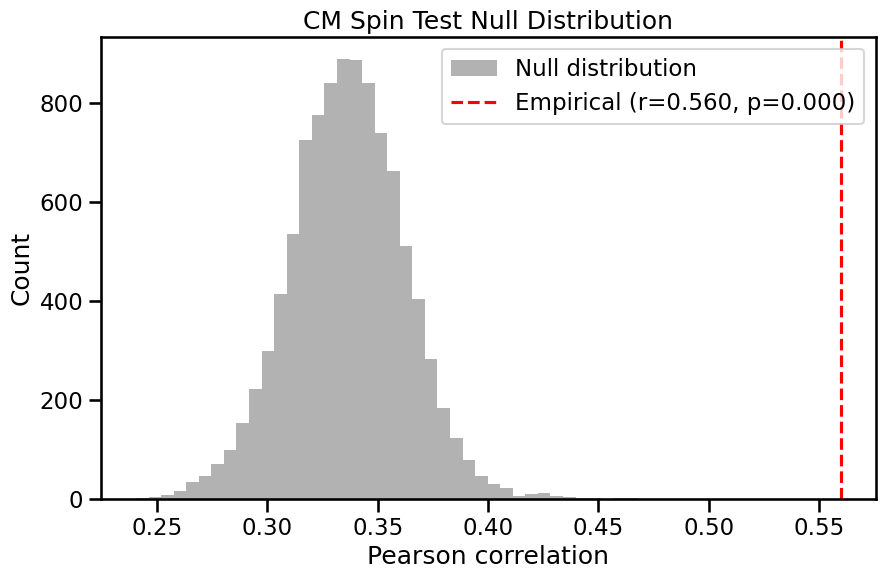

In [63]:
empirical_corr, p_value, null_distribution_SCM_10k = run_spin_test(
    X=X_pca,
    valid_indices=valid_indices,
    Y_true=Y,
    spins_df=spins_df_10k,
    model_type='CM',
    sort_spins='mean_error_rank',
    n_perms=10000
)
empirical_corr, p_value, null_distribution_PLS_10k = run_spin_test(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y,
    spins_df=spins_df_10k,
    model_type='PLS',
    sort_spins='mean_error_rank',
    n_perms=10000
)

# spins_df_10k = spins_df_10k.sort_values('mean_error_rank', ascending=True)
# spins_df_10k['pearsonr_SCM'] = null_distribution_SCM_10k
# spins_df_10k['pearsonr_PLS'] = null_distribution_PLS_10k
#spins_df_10k.to_csv('./data/enigma/10000_null_spins.csv', index=False)
# spins_df_10k.head(10)

Generate distribution for true random permutations

permutation: 0
permutation: 50
permutation: 100
permutation: 150
permutation: 200
permutation: 250
permutation: 300
permutation: 350
permutation: 400
permutation: 450
permutation: 500
permutation: 550
permutation: 600
permutation: 650
permutation: 700
permutation: 750
permutation: 800
permutation: 850
permutation: 900
permutation: 950


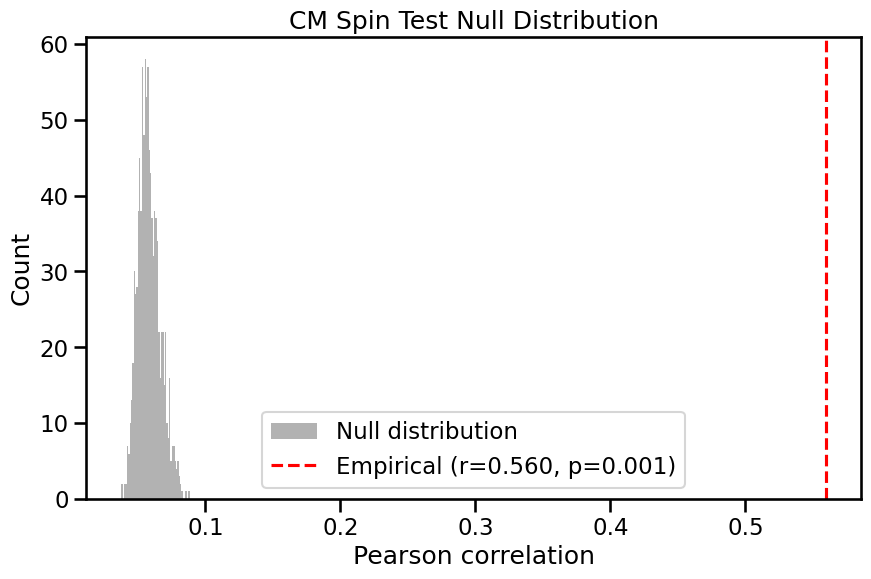

In [55]:
empirical_corr, p_value, null_distribution_SCM_random = run_spin_test_random(
    X=X_pca,
    valid_indices=valid_indices,
    Y_true=Y,
    spins_df=spins_df_random,
    model_type='CM',
    n_perms=1000
)

empirical_corr, p_value, null_distribution_PLS_spatial_random = run_spin_test(
    X=X,
    valid_indices=valid_indices,
    Y_true=Y,
    spins_df=spins_df_spatial_random,
    model_type='PLS',
    sort_spins=None,
    n_perms=1000
)

# spins_df_random['pearsonr_SCM'] = null_distribution_SCM_random
# spins_df_random['pearsonr_PLS'] = null_distribution_PLS_random
# #spins_df_random.to_csv('./data/enigma/1000_true_random_spins.csv', index=False)

### Compare distributions for different permutation types

In [56]:
spins_df_10k = pd.read_csv('./data/enigma/10000_null_spins.csv')
spins_df_spatial_random = pd.read_csv('./data/enigma/1000_spatial_random_spins.csv')
spins_df_random = pd.read_csv('./data/enigma/1000_true_random_spins.csv')

In [61]:
def plot_null_distributions(model_type='CM', fontsize=14):
    """
    Plot multiple null distributions with empirical value for a given model type
    
    Parameters:
    -----------
    model_type : str
        'CM' or 'PLS' - which model results to plot
    fontsize : int
        Font size for plot text elements
    """
    plt.figure(figsize=(10, 6))

    # Get empirical correlation based on model type
    if model_type == 'CM':
        empirical_corr, _, _ = run_spin_test(
            X=X_pca,
            valid_indices=valid_indices,
            Y_true=Y,
            spins_df=spins_df_1k,
            model_type=model_type,
            sort_spins='mean_error_rank',
            n_perms=1
        )
        null_dist_col = 'pearsonr_CM'
    else:  # PLS
        empirical_corr, _, _ = run_spin_test(
            X=X,
            valid_indices=valid_indices,
            Y_true=Y,
            spins_df=spins_df_1k,
            model_type=model_type,
            sort_spins='mean_error_rank',
            n_perms=1
        )
        null_dist_col = 'pearsonr_PLS'
    
    # Sort and get distributions
    spins_df_10k_sorted = spins_df_10k.sort_values('mean_error_rank', ascending=True)
    spins_10k_null_dist = spins_df_10k_sorted[null_dist_col].values
    
    # Get top 1k and random 1k from 10k spins
    spins_10k_top1k = spins_10k_null_dist[:1000]
    random_indices = np.random.choice(np.arange(9000, 10000), size=1000, replace=False)
    spins_10k_random1k = spins_10k_null_dist[random_indices]
    
    # Get spatial random and true random distributions
    spatial_random_dist = spins_df_spatial_random[null_dist_col].values
    true_random_dist = spins_df_random[null_dist_col].values

    # Plot distributions
    distributions = [
        (true_random_dist, 'True Random', 'orange'),
        (spatial_random_dist, 'Spatial Random', 'purple'),
        (spins_10k_random1k, 'Worst 1k from 10k', 'green'),
        (spins_10k_top1k, 'Best 1k from 10k', 'blue')
    ]
    
    for dist, label, color in distributions:
        mean_val = np.mean(dist)
        plt.hist(dist, bins=50, alpha=0.4, color=color,
                label=f'{label} (mean={mean_val:.3f})', density=True)
    
    plt.axvline(empirical_corr, color='red', linestyle='--',
                label=f'Empirical (r={empirical_corr:.3f})')
    
    plt.xlabel('Pearson correlation', fontsize=fontsize)
    plt.ylabel('Density', fontsize=fontsize)
    plt.title(f'{model_type} Spin Test Null Distributions', fontsize=fontsize)
    plt.legend(fontsize=fontsize-2)
    plt.tick_params(labelsize=fontsize-2)
    plt.show()

permutation: 0


<Figure size 1000x600 with 0 Axes>

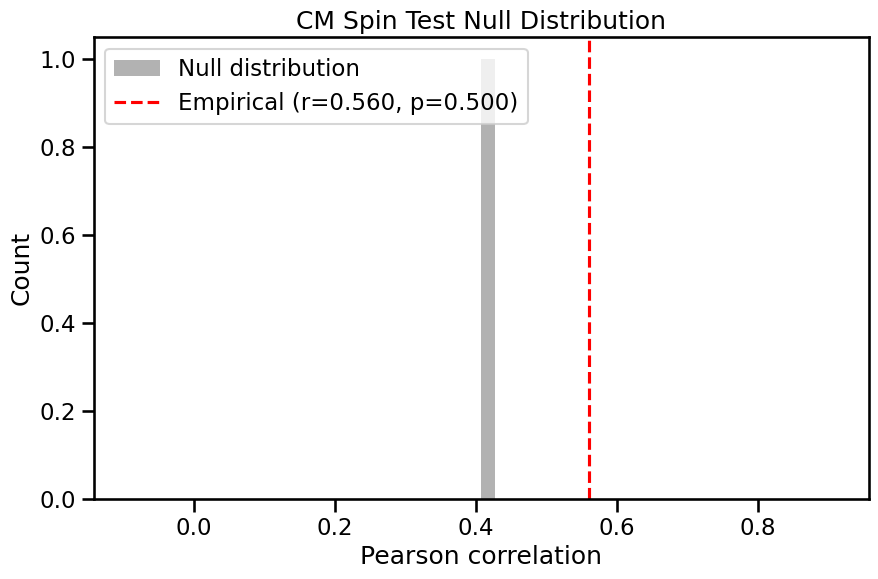

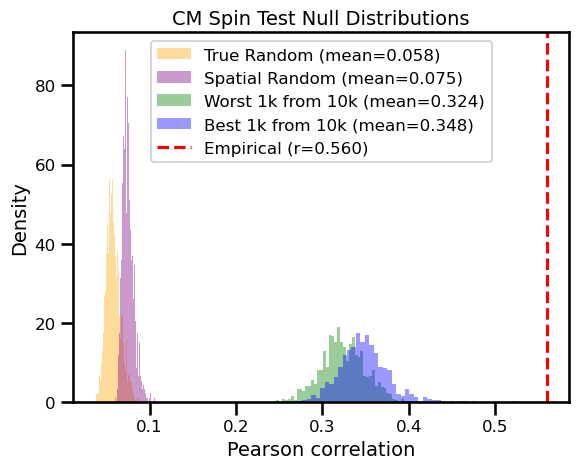

In [62]:

# Plot CM distributions
plot_null_distributions(model_type='CM')

permutation: 0


<Figure size 1000x600 with 0 Axes>

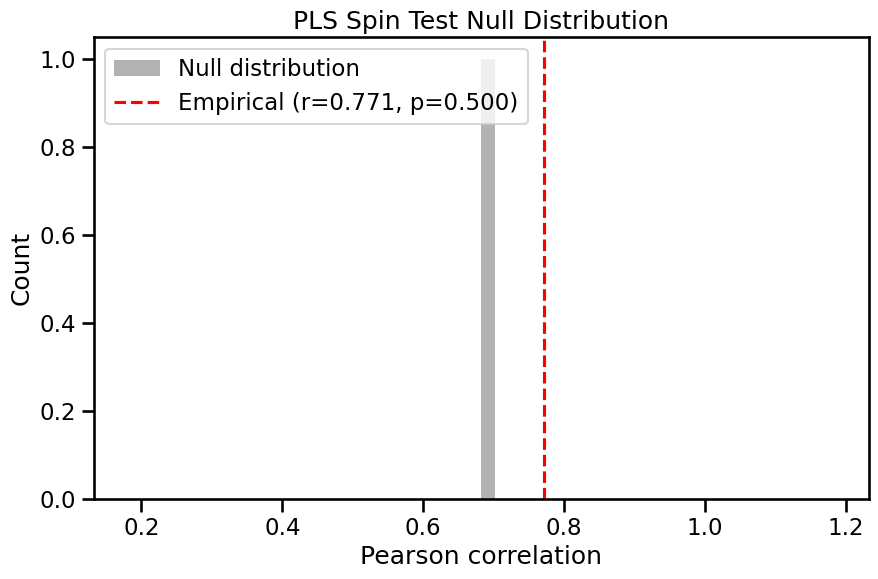

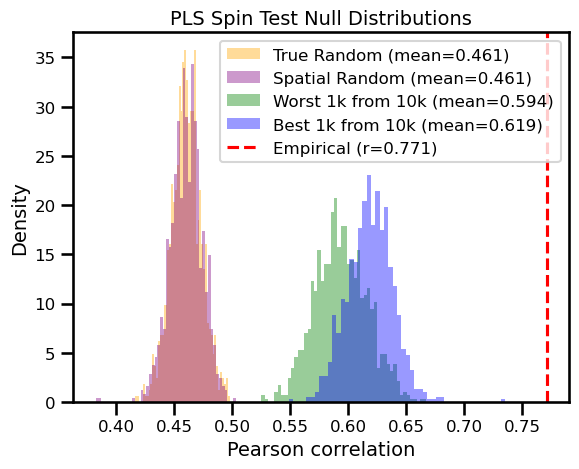

In [63]:

# Plot CM distributions
plot_null_distributions(model_type='PLS')

In [98]:
def plot_top_10_vs_full_distribution(X, Y, valid_indices, spins_df_10k, spins_df_random, model_types=['CM', 'PLS'], n_top=10, figsize=(10,6), fontsize=14):
    """
    Plot comparison of full null distribution vs random spins for specified models.
    
    Args:
        spins_df_10k: DataFrame containing 10k spin results
        spins_df_random: DataFrame containing random spin results
        model_types: List of model types to plot (e.g. ['CM', 'PLS'])
        n_top: Number of top spins to average (default 10)
        figsize: Figure size tuple (default (10,6))
        fontsize: Base font size for plot text (default 14)
    """
    # Sort spins_df by mean_error_rank
    spins_df_10k = spins_df_10k.sort_values('mean_error_rank')
    
    for model in model_types:
        # Get relevant columns
        null_dist_col = f'pearsonr_{model}'
        null_dist = spins_df_10k[null_dist_col].values
        random_dist = spins_df_random[null_dist_col].values
        
        # Calculate statistics
        dist_mean = np.mean(null_dist)
        random_mean = np.mean(random_dist)
        top_n_mean = np.mean(null_dist[:n_top])
        
        # Get empirical correlation
        if model == 'CM':
            empirical_corr, _, _ = run_spin_test(
                X=X_pca,
                valid_indices=valid_indices,
                Y_true=Y,
                spins_df=spins_df_10k,
                model_type=model,
                sort_spins='mean_error_rank',
                n_perms=1
            )
        else:  # PLS
            empirical_corr, _, _ = run_spin_test(
                X=X,
                valid_indices=valid_indices,
                Y_true=Y,
                spins_df=spins_df_10k,
                model_type=model,
                sort_spins='mean_error_rank',
                n_perms=1
            )
        
        # Create plot
        plt.figure(figsize=figsize)
        plt.hist(null_dist, bins=50, alpha=0.4, 
                color='blue' if model=='CM' else 'green',
                label=f'10k Spin Distribution')
        
        # Add vertical lines
        plt.axvline(dist_mean, color='black', linestyle='--',
                   label=f'10k Spin Mean (r={dist_mean:.3f})')
        plt.axvline(empirical_corr, color='green', linestyle='--',
                   label=f'Empirical (r={empirical_corr:.3f})')
        plt.axvline(top_n_mean, color='blue', linestyle='--',
                   label=f'Top {n_top} Spin Tests Mean (r={top_n_mean:.3f})')
        plt.axvline(dist_mean, color='black', linestyle='--',
                   label=f'Overall 10k Spin Mean (r={dist_mean:.3f})')
        plt.axvline(random_mean, color='purple', linestyle='--',
                   label=f'Random Spin Mean (r={random_mean:.3f})')
        
        # Customize plot
        plt.xlabel('Pearson correlation', fontsize=fontsize)
        plt.ylabel('Count', fontsize=fontsize)
        plt.title(f'{model} 10k Null Spin Test Correlation Distribution', fontsize=fontsize)
        plt.legend(fontsize=fontsize-10)
        plt.tick_params(labelsize=fontsize-2)
        plt.show()

permutation: 0


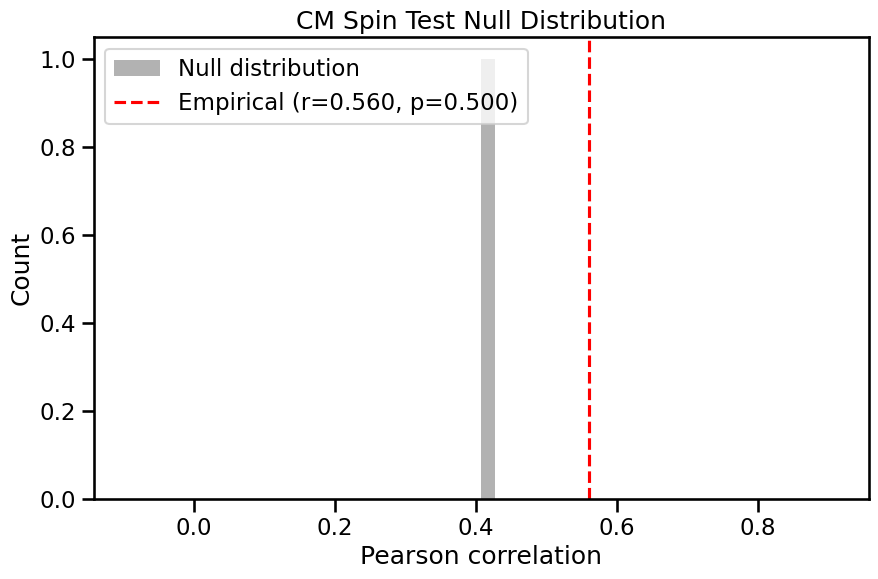

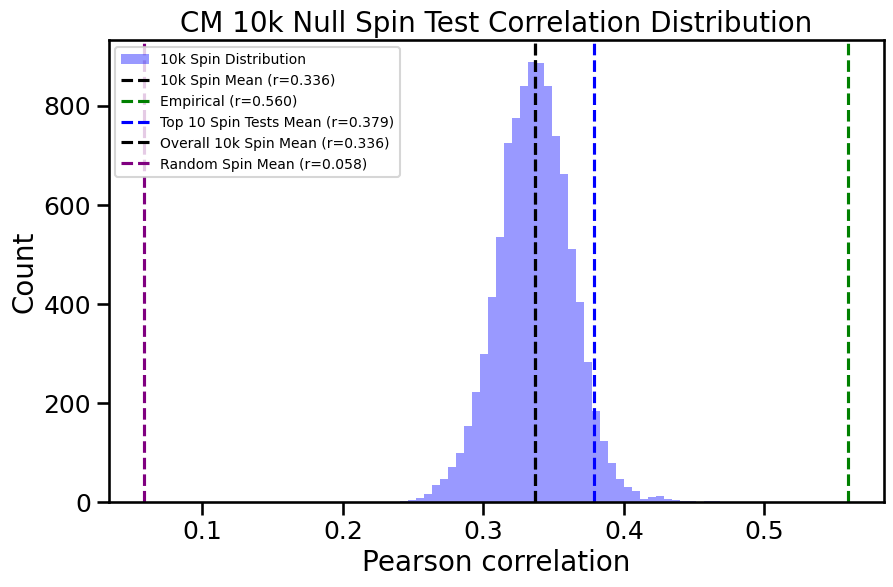

permutation: 0


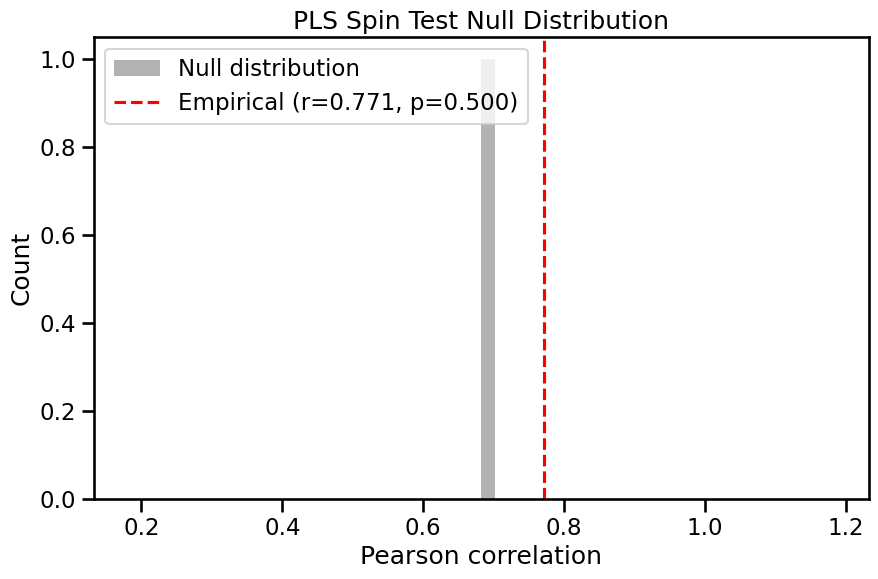

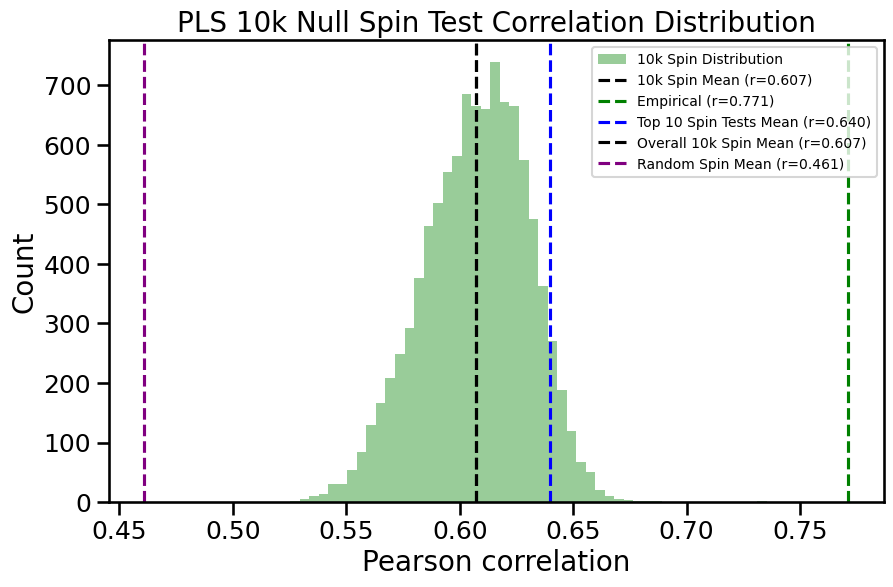

In [99]:
plot_top_10_vs_full_distribution(X, Y, valid_indices, spins_df_10k, spins_df_random, model_types=['CM', 'PLS'], n_top=10, figsize=(10,6), fontsize=20)


In [105]:
load_transcriptome(parcellation='S400', omit_subcortical=False, hemisphere='both', impute_strategy='mirror_interpolate', sort_genes='expression', null_model='spin', random_seed=42)

Spinning gene expression
Spin index for seed 42: 9
Mean error rank for spin index 9: 263.3333333333333


array([[0.15136387, 0.187843  , 0.13702233, ..., 0.82175135, 0.87288001,
        0.87122648],
       [0.19016599, 0.3056109 , 0.38667427, ..., 0.73830012, 0.80667109,
        0.72479233],
       [0.13215955, 0.22330828, 0.14797115, ..., 0.83984844, 0.88073275,
        0.88292539],
       ...,
       [0.93402434, 0.76850929, 0.89890416, ..., 0.14037945, 0.15545229,
        0.21484031],
       [0.93366045, 0.60176965, 0.91456171, ..., 0.19777217, 0.15494885,
        0.24945851],
       [0.93379317, 0.73564927, 0.88389181, ..., 0.12728142, 0.12433205,
        0.19600795]])